In [ ]:
####################  Deep Learning Script for Bainite - Martensite Classification       ########################

####################  Written by Juancheng Li, Modified by Xiaohan Bie 2022-07-04       ########################
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

# folder path
base_dir = '/content/drive/My Drive/SURE Summer 2022/'
train_dir = os.path.join(base_dir, 'train2')
validation_dir = os.path.join(base_dir, 'validation2')
test_dir = os.path.join(base_dir, 'test2')

Mounted at /content/drive


In [ ]:
# setting parameters
initial_epochs=40
fine_tune_epochs = 30

In [ ]:
# load image dataset
training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224, 224))
validation_set = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(224, 224))
# load image dataset
test_set = image_dataset_from_directory(test_dir,
                                             shuffle=False,
                                             batch_size=32,
                                             image_size=(224, 224))


Found 2140 files belonging to 2 classes.
Found 536 files belonging to 2 classes.
Found 180 files belonging to 2 classes.


In [ ]:
# data augmentation (add preprocessing layers to model)
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomFlip("horizontal_and_vertical"),
])


In [ ]:
# define based model = VGG19
# define input shape as 224 x 224 x 3
# dataset trained on is imagenet
preprocess_input = tf.keras.applications.vgg19.preprocess_input
base_model = keras.applications.vgg19.VGG19(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)  # discard FC layer from VGG19  model

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# freeze base model layers
base_model.trainable = False

# define input sizes to deep learning model
inputs = keras.Input(shape=(224, 224, 3))

# augment data
x = data_augmentation(inputs)

preprocess_input = tf.keras.applications.xception.preprocess_input
# preprocess input values scale to (-1,1) to fit Xception  model
x = preprocess_input(x)

# build FC layer with our image dataset x
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)

In [ ]:
# compile model and train
initial_epochs=40
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = model.fit(training_set, epochs=initial_epochs, validation_data=validation_set)


Epoch 1/40
67/67 [==============================] - 427s 6s/step - loss: 0.6692 - binary_accuracy: 0.5949 - precision: 0.6009 - recall: 0.7861 - auc: 0.6148 - val_loss: 0.6278 - val_binary_accuracy: 0.7201 - val_precision: 0.6764 - val_recall: 0.9424 - val_auc: 0.7972
Epoch 2/40
67/67 [==============================] - 16s 225ms/step - loss: 0.6178 - binary_accuracy: 0.6729 - precision: 0.6591 - recall: 0.8404 - auc: 0.7352 - val_loss: 0.5889 - val_binary_accuracy: 0.7593 - val_precision: 0.7255 - val_recall: 0.9051 - val_auc: 0.8290
Epoch 3/40
67/67 [==============================] - 16s 230ms/step - loss: 0.5867 - binary_accuracy: 0.7243 - precision: 0.7118 - recall: 0.8387 - auc: 0.7894 - val_loss: 0.5620 - val_binary_accuracy: 0.7705 - val_precision: 0.7722 - val_recall: 0.8271 - val_auc: 0.8403
Epoch 4/40
67/67 [==============================] - 16s 236ms/step - loss: 0.5647 - binary_accuracy: 0.7346 - precision: 0.7230 - recall: 0.8396 - auc: 0.8015 - val_loss: 0.5426 - val_binar

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall', 'val_auc'])


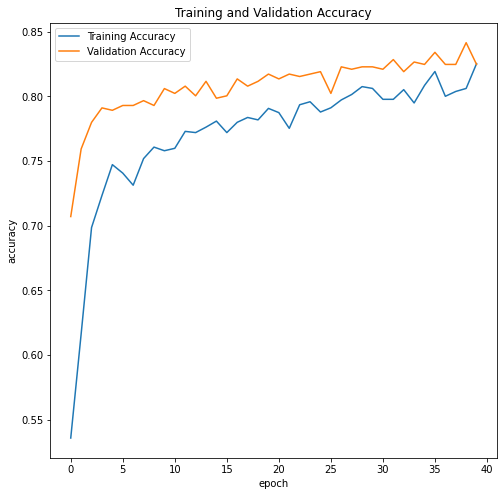

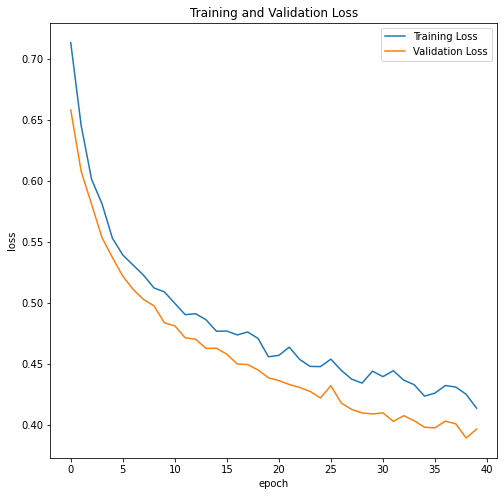

In [ ]:
##################################################
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))


plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
##################################################

In [ ]:
test = model.evaluate(test_set)
print('test set loss:' + str(test[0]))
print('test set accuracy:' + str(test[1]))

6/6 [==============================] - 20s 3s/step - loss: 0.3225 - binary_accuracy: 0.8833 - precision: 0.8529 - recall: 0.9355 - auc: 0.9747
test set loss:0.3225420117378235
test set accuracy:0.8833333253860474


In [ ]:
base_model = model.layers[4]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 16
base_learning_rate = 0.001
total_epochs =  initial_epochs + fine_tune_epochs

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function=tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

metrics=[keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_set,
                         )






Number of layers in the base model:  22
Epoch 40/70
67/67 [==============================] - 24s 301ms/step - loss: 0.4964 - binary_accuracy: 0.7911 - precision_1: 0.8043 - recall_1: 0.8200 - auc_1: 0.8617 - val_loss: 0.3134 - val_binary_accuracy: 0.8246 - val_precision_1: 0.9902 - val_recall_1: 0.6881 - val_auc_1: 0.9926
Epoch 41/70
67/67 [==============================] - 21s 300ms/step - loss: 0.2138 - binary_accuracy: 0.9154 - precision_1: 0.9272 - recall_1: 0.9185 - auc_1: 0.9733 - val_loss: 0.1999 - val_binary_accuracy: 0.9011 - val_precision_1: 0.9919 - val_recall_1: 0.8271 - val_auc_1: 0.9942
Epoch 42/70
67/67 [==============================] - 20s 287ms/step - loss: 0.1306 - binary_accuracy: 0.9509 - precision_1: 0.9566 - recall_1: 0.9542 - auc_1: 0.9896 - val_loss: 0.6645 - val_binary_accuracy: 0.7071 - val_precision_1: 1.0000 - val_recall_1: 0.4678 - val_auc_1: 0.9954
Epoch 43/70
67/67 [==============================] - 21s 300ms/step - loss: 0.1437 - binary_accuracy: 0.9458

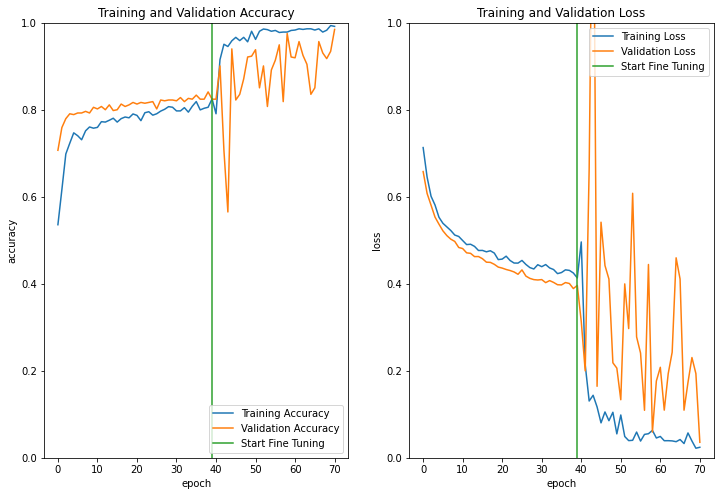

In [ ]:
#output accuracy and plot figures


acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']




plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('loss-fine-tuning.png',dpi='figure')

In [ ]:
test2 = model.evaluate(test_set)
print('test set loss:' + str(test2[0]))
print('test set accuracy:' + str(test2[1]))

6/6 [==============================] - 1s 233ms/step - loss: 0.1136 - binary_accuracy: 0.9556 - precision_1: 1.0000 - recall_1: 0.9140 - auc_1: 0.9991
test set loss:0.11355685442686081
test set accuracy:0.9555555582046509


In [ ]:
model.save(os.path.join(base_dir, 'VGG19.h5'))